<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Customer-age-estimation-using-convolutional-neural-networks-(CNNs)-on-GPUs" data-toc-modified-id="Customer-age-estimation-using-convolutional-neural-networks-(CNNs)-on-GPUs-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Customer age estimation using convolutional neural networks (CNNs) on GPUs</a></span></li><li><span><a href="#Exploratory-Data-Analysis" data-toc-modified-id="Exploratory-Data-Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Exploratory Data Analysis</a></span><ul class="toc-item"><li><span><a href="#Dataset-size" data-toc-modified-id="Dataset-size-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Dataset size</a></span></li><li><span><a href="#Distribution-of-ages-in-the-dataset" data-toc-modified-id="Distribution-of-ages-in-the-dataset-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Distribution of ages in the dataset</a></span></li><li><span><a href="#Random-Sample-of-Photos" data-toc-modified-id="Random-Sample-of-Photos-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Random Sample of Photos</a></span></li></ul></li><li><span><a href="#Building-and-Training-the-Neural-Network" data-toc-modified-id="Building-and-Training-the-Neural-Network-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Building and Training the Neural Network</a></span><ul class="toc-item"><li><span><a href="#Helper-Functions" data-toc-modified-id="Helper-Functions-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Helper Functions</a></span><ul class="toc-item"><li><span><a href="#Loading-Training-and-Test-Datasets" data-toc-modified-id="Loading-Training-and-Test-Datasets-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Loading Training and Test Datasets</a></span></li><li><span><a href="#ResNet50-based-model" data-toc-modified-id="ResNet50-based-model-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>ResNet50 based model</a></span></li></ul></li><li><span><a href="#Training/Testing" data-toc-modified-id="Training/Testing-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Training/Testing</a></span></li></ul></li><li><span><a href="#Conclusion:" data-toc-modified-id="Conclusion:-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Conclusion:</a></span></li></ul></div>

# Customer age estimation using convolutional neural networks (CNNs) on GPUs


A supermarket chain is implementing a computer vision system to process customer photos. Capturing images at the checkout area will help estimate customers' ages in order to:

- Analyze purchases and recommend products that may interest customers in that age group.
- Ensure cashiers comply with alcohol sales regulations.



**Objective:** Train a neural network based on ResNet50 to predict a person’s age from their image

**Tasks**:

* Conduct an exploratory analysis of the photo dataset.
* Prepare the data for training.
* Train a neural network and evaluate its performance.

We have a dataset of photographs with the corresponding ages of individuals.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

from vision_helper_functions import (
                              load_train
                             ,load_test
                             ,create_model
                             ,train_model)

path = '../datasets/faces/'
verbose = True
rseed =12345       

# Exploratory Data Analysis

## Dataset size

In [2]:
datagen = ImageDataGenerator(rescale=1/255.)
datagen_flow = datagen.flow_from_directory(
    path,
    target_size=(150, 150),
    batch_size=16,
    class_mode='sparse',
    seed=12345)

Found 7591 images belonging to 1 classes.


The dataset contains a total of 7591 images.

## Distribution of ages in the dataset

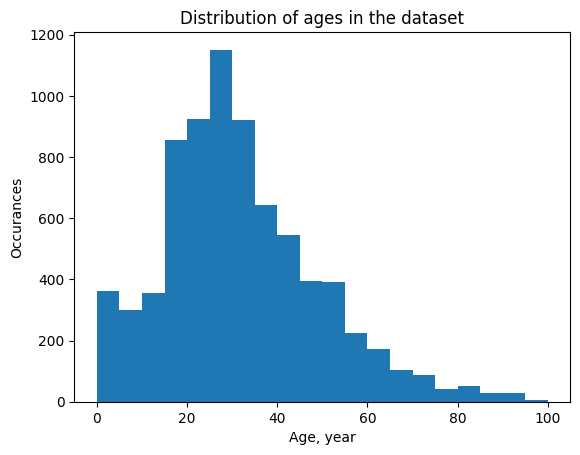

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [3]:
target_age = pd.read_csv(path+'labels.csv')
plt.hist(target_age['real_age'],bins=20, range=(0,100))
plt.ylabel('Occurances')
plt.xlabel('Age, year')
plt.title('Distribution of ages in the dataset')
plt.show()
target_age.describe()

 The age distribution in the dataset is skewed to the left, with a mean age of 31 years. There are many photos of young children and fewer of elderly individuals. 

## Random Sample of Photos

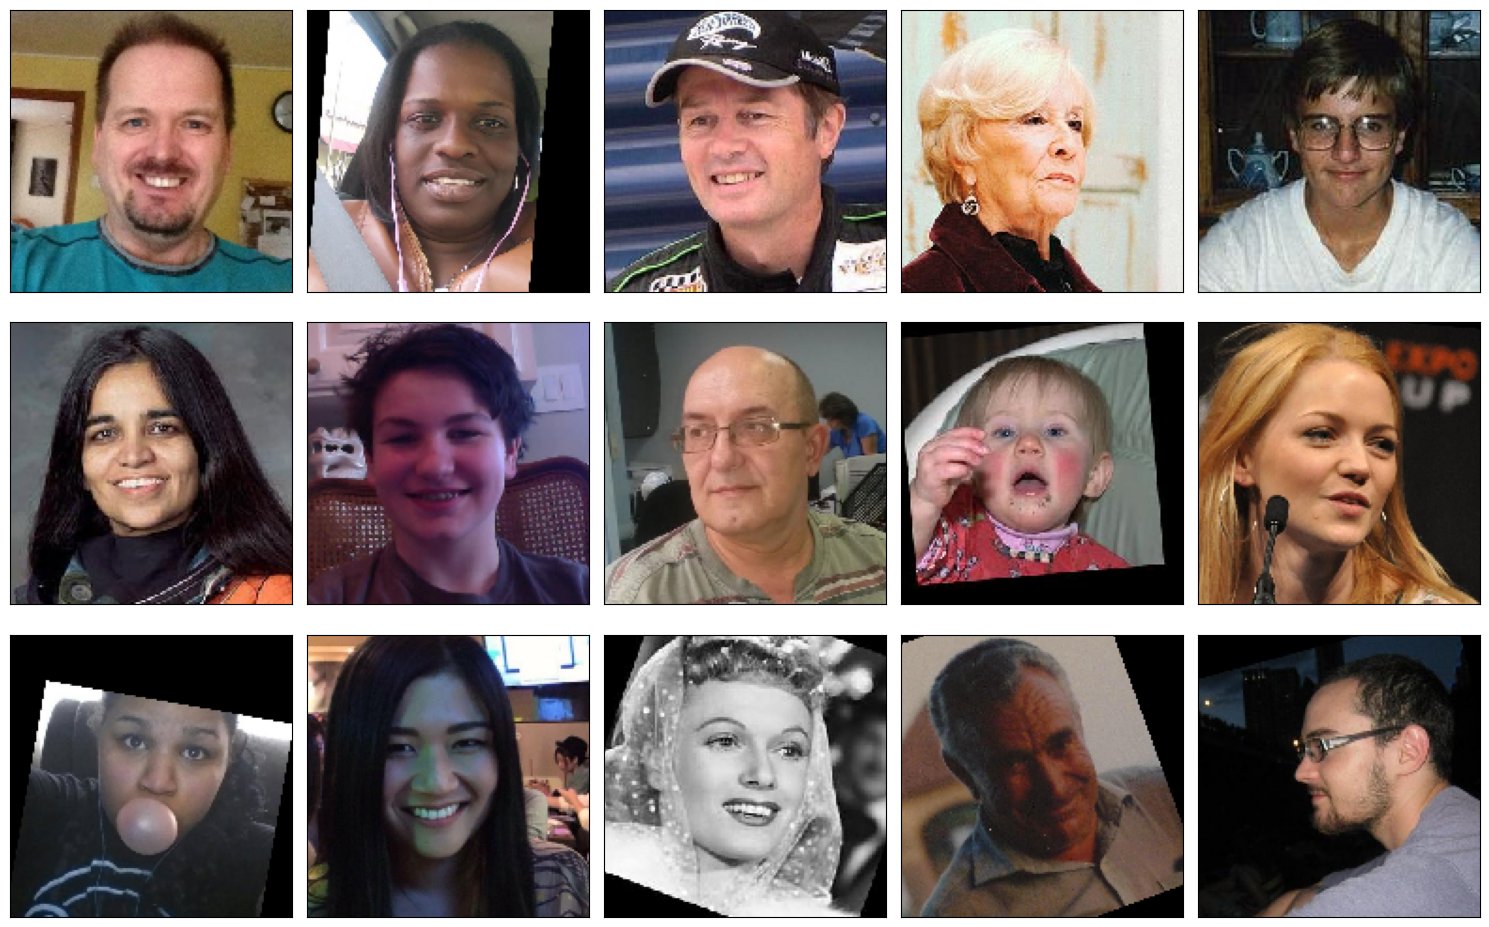

In [4]:
features, target = next(datagen_flow)
# display 15 photos
fig = plt.figure(figsize=(15,10))
for i in range(15):
    fig.add_subplot(3, 5, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

The image dataset includes real people of various ages, genders, and skin tones, as well as actors from movies. The photos vary in resolution and quality.


# Building and Training the Neural Network

We will split the data into training and test sets in a 75%/25% ratio. We will gradually adjust the parameters of a pre-trained ResNet50 neural network, replacing the first (input) layer and the last layer, where we will use a single neuron for predictions.

## Helper Functions

- `load_train(path)` - generates the training dataset.
- `load_test(path)` - generates the test dataset.
- `create_model(input_shape, path)` - creates a model with the specified input layer size.
- `train_model(model, train_data, test_data, batch_size, epochs, steps_per_epoch, validation_steps)` - starts the training.

### Loading Training and Test Datasets

In [5]:
train_data = load_train(path)
test_data =  load_test(path)

features, target = next(train_data)


input_shape = features[0].shape
print('Input image size',input_shape)

Found 5694 validated image filenames.
Found 1897 validated image filenames.
Input image size (150, 150, 3)


### ResNet50 based model

In the output layer, we have a single neuron with a "relu" activation function, which produces a non-negative numerical result, suitable for age prediction. 

In [6]:
model = create_model(input_shape,path)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________


The model needs further training to update 23,536,641 parameters of the neural network. 

## Training/Testing

We'll use a small batch size and less than 10 epochs.

In [7]:
batch_size = 16
epochs = 9
model_out = train_model(model, train_data, test_data,batch_size,epochs)

Epoch 1/9
356/356 - 52s - loss: 300.2234 - mae: 12.3372 - val_loss: 654.2785 - val_mae: 20.3033 - 52s/epoch - 145ms/step
Epoch 2/9
356/356 - 28s - loss: 80.3073 - mae: 6.8119 - val_loss: 202.3233 - val_mae: 10.8982 - 28s/epoch - 78ms/step
Epoch 3/9
356/356 - 29s - loss: 50.8879 - mae: 5.5246 - val_loss: 80.1606 - val_mae: 6.7782 - 29s/epoch - 80ms/step
Epoch 4/9
356/356 - 28s - loss: 34.1936 - mae: 4.5425 - val_loss: 74.6187 - val_mae: 6.5847 - 28s/epoch - 79ms/step
Epoch 5/9
356/356 - 28s - loss: 26.4570 - mae: 4.0111 - val_loss: 112.9736 - val_mae: 7.9984 - 28s/epoch - 78ms/step
Epoch 6/9
356/356 - 29s - loss: 22.6835 - mae: 3.6813 - val_loss: 72.1281 - val_mae: 6.4752 - 29s/epoch - 80ms/step
Epoch 7/9
356/356 - 28s - loss: 17.9773 - mae: 3.2700 - val_loss: 74.2993 - val_mae: 6.6346 - 28s/epoch - 79ms/step
Epoch 8/9
356/356 - 28s - loss: 16.2163 - mae: 3.0848 - val_loss: 86.8000 - val_mae: 6.9306 - 28s/epoch - 78ms/step
Epoch 9/9
356/356 - 28s - loss: 14.9017 - mae: 2.9442 - val_loss

On the test dataset, the model reached MAE of 6.7 after 9 epochs. The MSE metric gradually decreased on both the training and test sets. The MSE on the test set is 3-5 times higher than on the training set, and this difference remains consistent throughout the training.

In [8]:
features_test, target_test = test_data.next()
print(target_test)

[26 17 28 28 13 41  7 23 14 54 15 38 40 30 47 23]


In [9]:
features_test, target_test = test_data.next()
print(target_test)

[30 20  2 49 47 25 80 30 90 18 30 40 20 40 39  4]


Let's examine the difference between predicted and actual ages.

1/1 - 1s - 764ms/epoch - 764ms/step


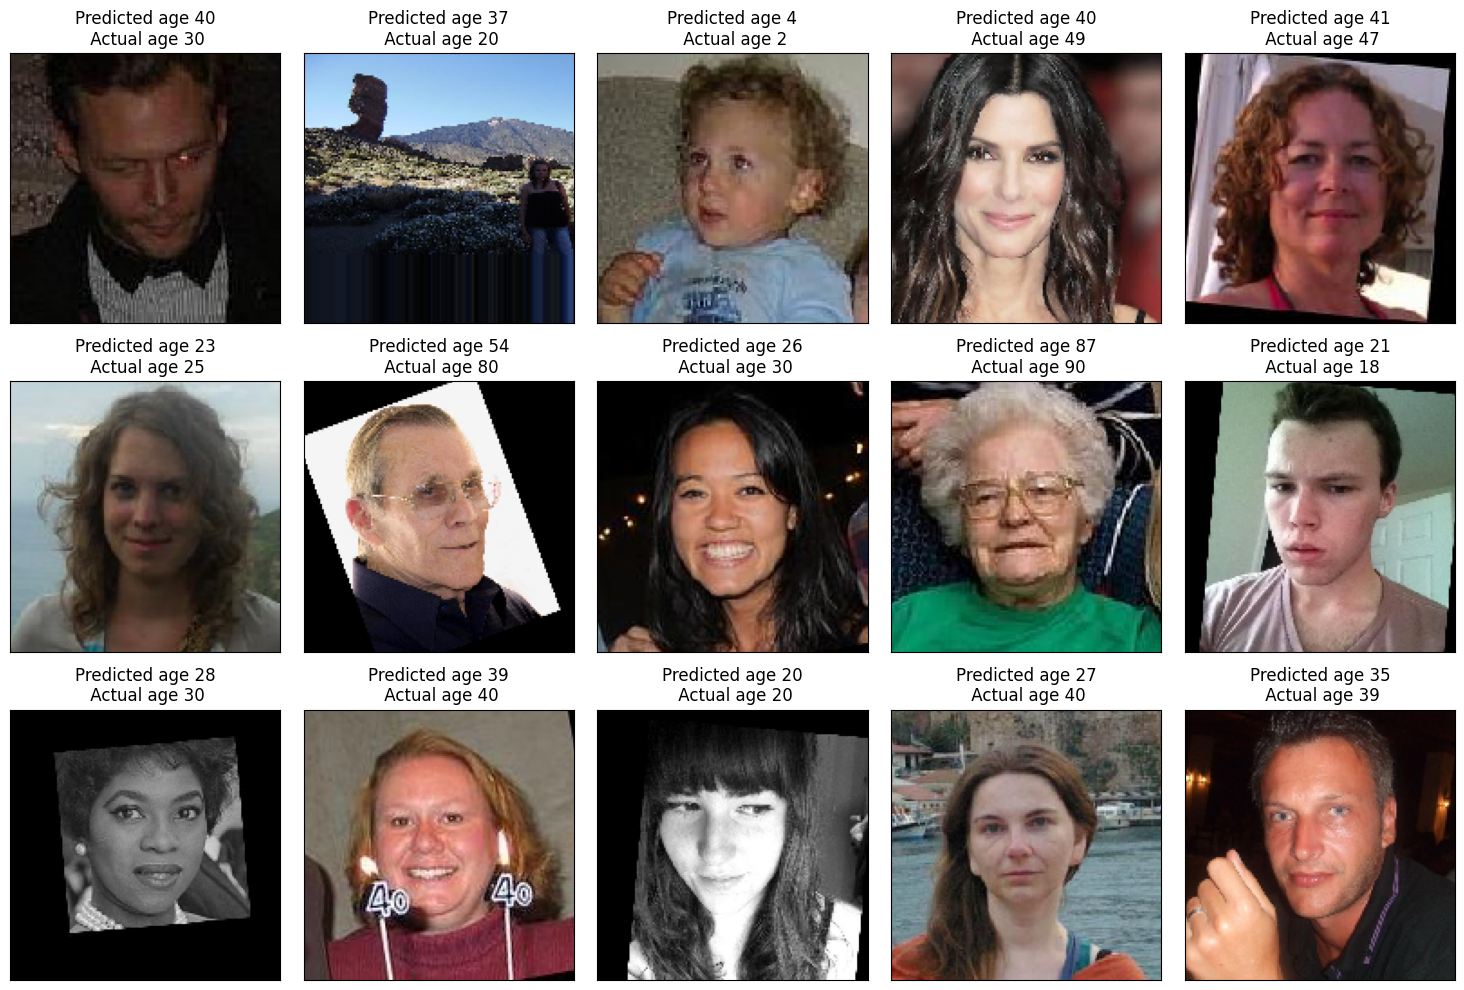

In [10]:

predicted_ages = model_out.predict(features_test,verbose=2)
    
fig = plt.figure(figsize=(15,10))
for i in range(15):
    fig.add_subplot(3, 5, i+1)
    plt.title(f'Predicted age {int(predicted_ages[i][0])}\n Actual age {int(target_test[i])}')
    plt.imshow(features_test[i])

    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Overall, the model performs well; I'd say it's comparable to human estimation within the age group of 20-60 years.

In [11]:
model_out.evaluate(test_data)
predicted_ages = model_out.predict(test_data,verbose=2)
print(predicted_ages[0],len(predicted_ages))
predicted_ages = model_out.predict(test_data,verbose=2)
model_out.evaluate(test_data)
print(predicted_ages[0],len(predicted_ages))

119/119 [==============================] - 4s 32ms/step - loss: 75.7402 - mae: 6.6650
119/119 - 4s - 4s/epoch - 30ms/step
[25.015356] 1897
119/119 - 3s - 3s/epoch - 28ms/step
119/119 [==============================] - 4s 31ms/step - loss: 75.7402 - mae: 6.6651
[45.58702] 1897


# Conclusion:

* Using 7,591 photographs of people, we trained a ResNet50-based neural network to predict their ages, achieving a rather good MAE of 6.7.

* In general, the model can predict age groups (e.g., child, teenager) reasonably well, which should be suitable for suggesting products and services. However, for age verification in the context of alcohol sales, further investigation is needed to ensure the model's predictions align with the actual ages in the dataset to resolve minor discrepancies.